In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

import PyLasMech as plm

### Read well log datas

In [2]:
LogFiles=plm.FileFinder("../Data/Petrophysics")

[IO] Found 9 log files


,FileName,Location
0,15_9-F-11B_INPUT.LAS,..\Data\Petrophysics\15_9-F-11B\15_9-F-11B_INP...
1,15_9-F-12_INPUT.LAS,..\Data\Petrophysics\15_9-F-12\15_9-F-12_INPUT...
2,15_9-F-14_INPUT.las,..\Data\Petrophysics\15_9-F-14\15_9-F-14_INPUT...
3,15_9-F-15C_INPUT.las,..\Data\Petrophysics\15_9-F-15C\15_9-F-15C_INP...
4,15_9-F-15D_INPUT.LAS,..\Data\Petrophysics\15_9-F-15D\15_9-F-15D_INP...
5,15_9-F-1B_INPUT.LAS,..\Data\Petrophysics\15_9-F-1B\15_9-F-1B_INPUT...
6,15_9-F-1C_INPUT.LAS,..\Data\Petrophysics\15_9-F-1C\15_9-F-1C_INPUT...
7,15_9-F-4_INPUT.las,..\Data\Petrophysics\15_9-F-4\15_9-F-4_INPUT.las
8,15_9-F-5_INPUT.las,..\Data\Petrophysics\15_9-F-5\15_9-F-5_INPUT.las


In [3]:
WellLog=plm.ReadLas(LogFiles[2])
#Print las file summary table
plm.printLas(WellLog)

[IO] Reading F:\Course\PETE 4241\Projects\Data\Petrophysics\15_9-F-14\15_9-F-14_INPUT.las.....
Done!
[LAS Info]
Well Name= 15/9-F-14
Start/Step/End Depth=(566.000000:0.500000:12302.000000)
NULL value= -999.25
Common Depth= (9128.0, 12175.0)


,Curves,Available Depth (Non-NULL),Raw Min/Max Val,Unit,Comments
0,DEPTH:1,"[566.0, 12302.0]","[566.0, 12302.0]",F,DEPTH (BOREHOLE) {F10.1}
1,DEPTH:2,"[566.0, 12302.0]","[67920.0, 1476240.0]",.1IN,Measured Depth {I11}
2,DRHO,"[9113.5, 12266.0]","[-4565.193, 0.4886]",g/cm3,DRHO:UNKNOWN:rC:NONE:v1 {F13.4}
3,DT,"[3539.0, 12185.0]","[-13500.7943, 166.1029]",us/ft,DT:UNKNOWN:rC:NONE:v2 {F13.4}
4,DTS,"[9128.0, 12175.0]","[-5033.0199, 186.4474]",us/ft,DTS:UNKNOWN:rC:NONE:v1 {F13.4}
5,GR,"[566.0, 12270.5]","[0.845, 253.51]",API,GR:UNKNOWN:rC:NONE:v1 {F13.4}
6,NPHI,"[9113.5, 12257.0]","[-4569.2548, 0.48]",V/V_DECIMAL,NPHI:UNKNOWN:rC:NONE:v1 {F13.4}
7,PEF,"[9113.5, 12266.0]","[-4747.0517, 138.7173]",B/ELEC,PEF:UNKNOWN:rC:NONE:v1 {F13.4}
8,RD,"[9113.5, 12261.0]","[-4568.8572, 200.0]",UNKNOWN,RD:UNKNOWN:rC:NONE:v1 {F13.4}
9,RHOB,"[9113.5, 12266.0]","[-4576.0065, 2.8762]",g/cm3,RHOB:UNKNOWN:rC:NONE:v1 {F13.4}


### Geomechanical properties calculation

> ##### Parameter and unit setup

In [4]:
#Unit Converter
ft=0.3048 #m
g_cm3=1000 #kg/m3
g=9.8 #m/s2
meter=1
mega=1e6 #Mega
Pa=1 #Pa
us=0.000001 #us, micro seconds
psi=6894.76

#Basic paramters for Volve field
rho_w=1.0*g_cm3  #formation fluid density
rho_m=2.65*g_cm3 #rock matrix density
z_w=80*meter # ocean water depth @ https://www.offshore-technology.com/projects/volve-oil-field-north-sea/
RHOB_avg=1.75*g_cm3 # average bulk density above the reservoir, Z<2576 ft
phi0=0.37
beta=0.0266*(1/mega*Pa) #convert it unit back to Pa


#RHOB DT DTS etc from Log
l=WellLog
param=l.plm_param
GeoMechParams={}


#RHOB DT DTS etc from Log
NonNanIndex=param.getCommonNonNanIndex(l,["RHOB","DT","DTS"])

DZ=l[0][NonNanIndex]
#Auto unit setup
if(param.Units[0]=="F" or param.Units[0]=="f"): DZ=DZ*ft
elif(param.Units[0]=="M" or param.Units[0]=="m"): DZ=DZ*meter
else:print("!!!Unknown Unit!!!!")
    
if("RHOB" in param.CurveNames): 
    RHOB=l["RHOB"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("RHOB")]
    if(unit=="g/cm3"): RHOB=RHOB*g_cm3
    else:print("!!!Unknown Unit!!!!",unit)    
if("DT" in param.CurveNames): 
    DT=l["DT"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("DT")]
    if(unit=="us/ft"): DT=DT*us/ft
    else:print("!!!Unknown Unit!!!!",unit)  
if("DTS" in param.CurveNames): 
    DTS=l["DTS"][NonNanIndex]
    #Auto unit
    unit=param.Units[param.getCurveIndex("DTS")]
    if(unit=="us/ft"): DTS=DTS*us/ft
    else:print("!!!Unknown Unit!!!!",unit)   

> ##### Vertical stress & its gradient
$$
S_v=\rho _wgz_w+\bar{\rho}_bg\left( z_0-z_w \right) +\int_{z_0-z_w}^z{\rho _b\left( z \right) gdz}
$$

In [5]:
z_0=DZ[0]

#1. Overburden stress
Sv0=rho_w*g*z_w+RHOB_avg*g*(z_0-z_w)
Sv=[Sv0]+list(Sv0+integrate.cumtrapz(RHOB*g, DZ))
GeoMechParams["Sv"]=np.array(Sv)
GeoMechParams["Sv_grad"]=GeoMechParams["Sv"]/DZ

plm.showTable([DZ/1e3,GeoMechParams["Sv"]/1e6],['Depth_GOM(km)','Sv(MPa)'],preview=10)

+----+-----------------+-----------+
|    |   Depth_GOM(km) |   Sv(MPa) |
|----+-----------------+-----------|
|  0 |         2.78221 |   47.127  |
|  1 |         2.87518 |   49.4365 |
|  2 |         2.96814 |   51.804  |
|  3 |         3.06111 |   53.9933 |
|  4 |         3.15407 |   56.0226 |
|  5 |         3.24703 |   58.1079 |
|  6 |         3.34    |   60.1953 |
|  7 |         3.43296 |   62.2301 |
|  8 |         3.52593 |   64.3091 |
|  9 |         3.61889 |   66.3608 |
+----+-----------------+-----------+


> ##### Hydrostatic pressure in MPa.  
The pore pressure can be calculated as follows:  
$${{P}_{p}}={{\bar{\rho }}_{w}}g{z} $$

In [6]:
GeoMechParams["P_pore"]=rho_w*g*DZ

plm.showTable([DZ/1e3,GeoMechParams["P_pore"]/1e6],['Depth_GOM(km)','PorePressure(MPa)'],preview=10)

+----+-----------------+---------------------+
|    |   Depth_GOM(km) |   PorePressure(MPa) |
|----+-----------------+---------------------|
|  0 |         2.78221 |             27.2657 |
|  1 |         2.87518 |             28.1767 |
|  2 |         2.96814 |             29.0878 |
|  3 |         3.06111 |             29.9988 |
|  4 |         3.15407 |             30.9099 |
|  5 |         3.24703 |             31.8209 |
|  6 |         3.34    |             32.732  |
|  7 |         3.43296 |             33.643  |
|  8 |         3.52593 |             34.5541 |
|  9 |         3.61889 |             35.4651 |
+----+-----------------+---------------------+


> ##### Rock porosity
The rock porosity can be calculated using density log as follows:  
$$
\phi =\frac{\rho _m-\rho _b}{\rho _m-\rho _w}
$$

In [7]:
GeoMechParams["PORO"]=(rho_m-RHOB)/(rho_m-rho_w)

plm.showTable([DZ/1e3,GeoMechParams["PORO"]],['Depth_GOM(km)','Porosity'],preview=10)

+----+-----------------+------------+
|    |   Depth_GOM(km) |   Porosity |
|----+-----------------+------------|
|  0 |         2.78221 |  0.506182  |
|  1 |         2.87518 |  0.0613333 |
|  2 |         2.96814 |  0.039697  |
|  3 |         3.06111 |  0.273455  |
|  4 |         3.15407 |  0.295455  |
|  5 |         3.24703 |  0.115758  |
|  6 |         3.34    |  0.26697   |
|  7 |         3.43296 |  0.26697   |
|  8 |         3.52593 |  0.253697  |
|  9 |         3.61889 |  0.249636  |
+----+-----------------+------------+


> ##### Porosity by Athy's equation  
The effective vertical stress $\sigma'_v$ can be calculated as follows:
$$\sigma'_v=\sigma_v - p_p $$
The porosity can be calculated as follows:
$$\phi=\phi_0 e^{-\beta \sigma'_v} $$

In [8]:
Sv_eff=GeoMechParams["Sv"]-GeoMechParams["P_pore"]
plm.showTable([DZ/1e3,Sv_eff/1e6],['Depth_GOM(km)','Effective Sv(MPa)'],preview=10)

GeoMechParams["PORO_Athy"]=phi0*np.exp(-beta*Sv_eff)
plm.showTable([DZ/1e3,GeoMechParams["PORO_Athy"]],['Depth_GOM(km)','Porosity_Athy'],preview=10)

+----+-----------------+---------------------+
|    |   Depth_GOM(km) |   Effective Sv(MPa) |
|----+-----------------+---------------------|
|  0 |         2.78221 |             19.8613 |
|  1 |         2.87518 |             21.2597 |
|  2 |         2.96814 |             22.7162 |
|  3 |         3.06111 |             23.9945 |
|  4 |         3.15407 |             25.1128 |
|  5 |         3.24703 |             26.287  |
|  6 |         3.34    |             27.4633 |
|  7 |         3.43296 |             28.5871 |
|  8 |         3.52593 |             29.755  |
|  9 |         3.61889 |             30.8956 |
+----+-----------------+---------------------+
+----+-----------------+-----------------+
|    |   Depth_GOM(km) |   Porosity_Athy |
|----+-----------------+-----------------|
|  0 |         2.78221 |        0.218152 |
|  1 |         2.87518 |        0.210186 |
|  2 |         2.96814 |        0.202199 |
|  3 |         3.06111 |        0.195439 |
|  4 |         3.15407 |        0.189711 

> ##### Pore pressure by Athy's equation
The Pore pressure by Athy's can be calculated as follows:  
$$ p_p = \sigma_v +\frac{1}{\beta}\ln{\frac{\phi}{\phi_0}} $$

In [9]:
GeoMechParams["P_pore_Athy"]=GeoMechParams["Sv"]+1/beta*np.log(GeoMechParams["PORO"]/phi0)

plm.showTable([DZ/1e3,GeoMechParams["P_pore_Athy"]/1e6],['Depth_GOM(km)','PorePressure_Athy(MPa)'],preview=10)

+----+-----------------+--------------------------+
|    |   Depth_GOM(km) |   PorePressure_Athy(MPa) |
|----+-----------------+--------------------------|
|  0 |         2.78221 |                  58.9087 |
|  1 |         2.87518 |                 -18.1267 |
|  2 |         2.96814 |                 -32.1143 |
|  3 |         3.06111 |                  42.6261 |
|  4 |         3.15407 |                  47.5644 |
|  5 |         3.24703 |                  14.4236 |
|  6 |         3.34    |                  47.9258 |
|  7 |         3.43296 |                  49.9607 |
|  8 |         3.52593 |                  50.1225 |
|  9 |         3.61889 |                  51.5676 |
+----+-----------------+--------------------------+


c:\users\binpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [10]:
#Fix inf -inf value in data
for name, data in GeoMechParams.items():
        data[data==-np.inf]=np.nan
        data[data==np.inf]=np.nan
        #GeoMechParams[name]=data

In [11]:
plm.appendCurve(l,'Sv', GeoMechParams["Sv"]/1e6, unit='MPa',descr='PyLasMech overburden stress',dataIndex=NonNanIndex)
plm.appendCurve(l,'P_pore', GeoMechParams["P_pore"]/1e6, unit='MPa',descr='PyLasMech pore pressure',dataIndex=NonNanIndex)
plm.appendCurve(l,'PORO', GeoMechParams["PORO"], unit='-',descr='PyLasMech porosity',dataIndex=NonNanIndex)
plm.appendCurve(l,'PORO_Athy', GeoMechParams["PORO_Athy"], unit='-',descr='PyLasMech porosity from Athy',dataIndex=NonNanIndex)
plm.appendCurve(l,'P_pore_Athy', GeoMechParams["P_pore_Athy"]/1e6, unit='MPa',descr='PyLasMech pore pressure from Athy',dataIndex=NonNanIndex)

Input data size(6095) < DEPTH size (23473), NULL value (nan) will be added
Input data size(6095) < DEPTH size (23473), NULL value (nan) will be added
Input data size(6095) < DEPTH size (23473), NULL value (nan) will be added
Input data size(6095) < DEPTH size (23473), NULL value (nan) will be added
Input data size(6095) < DEPTH size (23473), NULL value (nan) will be added


> ##### (b) Shear modulus (G,MPa), Possion ratio and Youngs Modulus (E, MPa) only available for DT/DTS
$$
G=\rho_bV_{s}^{2}
\\
\nu =\frac{V_{p}^{2}-2V_{s}^{2}}{2\left( V_{p}^{2}-V_{s}^{2} \right)}
\\
E=2G\left( 1+\nu \right) 
$$

In [12]:
Vp=1/DT
Vs=1/DTS

plm.showTable([DZ/1e3,Vp,Vs],
           ['Depth(km)','$V_p$ (m/s)','$V_s$ (m/s)'])

GeoMechParams["G"]=RHOB*Vs*Vs
GeoMechParams["v"]=(Vp**2-2*Vs**2)/2/(Vp**2-Vs**2)
GeoMechParams["E"]=2*GeoMechParams["G"]*(1+GeoMechParams["v"]) 

plm.showTable([DZ/1e3,GeoMechParams["G"]/1e9,GeoMechParams["v"],GeoMechParams["E"]/1e9],['Depth(km)','G(GPa)','v','E(GPa)'])

+----+-------------+---------------+---------------+
|    |   Depth(km) |   $V_p$ (m/s) |   $V_s$ (m/s) |
|----+-------------+---------------+---------------|
|  0 |     2.78221 |       4257.15 |      -60.5601 |
|  1 |     2.87518 |       3718.96 |     1962.2    |
|  2 |     2.96814 |       4281.61 |     2318.76   |
|  3 |     3.06111 |       3441.49 |     2039.1    |
|  4 |     3.15407 |       3364.26 |     1940.46   |
|  5 |     3.24703 |       3650.13 |     1661.91   |
|  6 |     3.34    |       3352    |     1941.4    |
|  7 |     3.43296 |       3368.72 |     1965.4    |
|  8 |     3.52593 |       3333.11 |     1936.03   |
|  9 |     3.61889 |       3530.09 |     1983.46   |
+----+-------------+---------------+---------------+
+----+-------------+-------------+----------+------------+
|    |   Depth(km) |      G(GPa) |        v |     E(GPa) |
|----+-------------+-------------+----------+------------|
|  0 |     2.78221 |  0.00665582 | 0.499899 |  0.0199661 |
|  1 |     2.87518 |  

In [13]:
GeoMechParams["UCS"]=np.exp(-6.36+2.45*np.log10(0.86*Vp-1172))*mega*Pa
plm.showTable([DZ/1e3,GeoMechParams["UCS"]/1e6],['Depth(km)','UCS(MPa)'],preview=10)

+----+-------------+------------+
|    |   Depth(km) |   UCS(MPa) |
|----+-------------+------------|
|  0 |     2.78221 |    7.10163 |
|  1 |     2.87518 |    5.70549 |
|  2 |     2.96814 |    7.1655  |
|  3 |     3.06111 |    4.99336 |
|  4 |     3.15407 |    4.79622 |
|  5 |     3.24703 |    5.5283  |
|  6 |     3.34    |    4.76496 |
|  7 |     3.43296 |    4.80758 |
|  8 |     3.52593 |    4.71682 |
|  9 |     3.61889 |    5.22012 |
+----+-------------+------------+


In [14]:
#Fix inf -inf value in data
for name, data in GeoMechParams.items():
        data[data==-np.inf]=np.nan
        data[data==np.inf]=np.nan
        #GeoMechParams[name]=data

#plm.appendCurve(l,'G', GeoMechParams["G"]/1e9, unit='GPa',descr='PyLasMech Bulk modulus',dataIndex=NonNanIndex)
plm.appendCurve(l,'v', GeoMechParams["v"], unit='-',descr='PyLasMech possion ratio',dataIndex=NonNanIndex)
plm.appendCurve(l,'E', GeoMechParams["E"]/1e9, unit='GPa',descr='PyLasMech Youngs modulus',dataIndex=NonNanIndex)
plm.appendCurve(l,'UCS', GeoMechParams["UCS"]/1e6, unit='MPa',descr='PyLasMech UCS',dataIndex=NonNanIndex)

Input data size(6095) < DEPTH size (23473), NULL value (nan) will be added
Input data size(6095) < DEPTH size (23473), NULL value (nan) will be added
Input data size(6095) < DEPTH size (23473), NULL value (nan) will be added


### Plot and visulization

	Auto Depth Range= (9128.0, 12175.0) for  ['Sv', 'P_pore', 'PORO', 'PORO_Athy', 'P_pore_Athy', 'v', 'E', 'UCS']
	 P_pore_Athy Corrected Min/Max Val [-209.9876160570306, 82.18576213263086]
	 v Corrected Min/Max Val [-0.004372421373305851, 0.49989879716448726]
	 E Corrected Min/Max Val [0.019966105121067123, 78.089229336852]
	 UCS Corrected Min/Max Val [3.4467315474783535, 10.588080367481059]


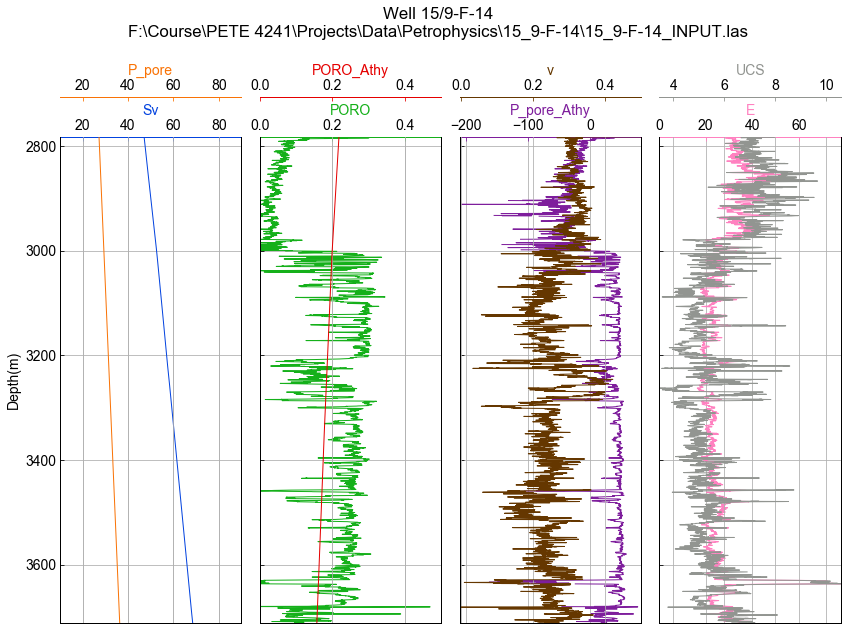

In [15]:
XLims={"P_pore":(10,90),"Sv":(10,90),"PORO_Athy":(0,0.5),"PORO":(0,0.5)}
fig=plm.plotLogs(LogData=l,CurveNames=GeoMechParams.keys(),XLims=XLims)